# Part 02. Extending notebook 1 with hooks, neuron health and visualization

## Overview/goals

This notebook is the **second** in a multi-part interpretability exploration. Here, we extend our study of MLP performance and interal exporation on non-normalized MNIST data. Our focus in this notebook is to investigate the following:

> - Neuron health
> - Gradient tracking
> - neuron 'importance' in the late hidden layers
> - the affect of ablation/scaling neuron activations on model accuracy
> - the geometry of the activation space
> - Various visualizations 'pixel activation maps'

We utilize/implement the following tools:

> - Hooks
> - Selectivity scores of neurons by class
> - confusion matrices
> - Visualizations:
>   - model accuracy under ablation/sclaing, PCA, UMAP
>   - gradient based salency maps
>   - one-hot perturbation maps
> - silhouette scores
> - etc

Let's get into it!

## Section 0. Setup

### 0.1. Imports

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from collections import defaultdict

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 0.1. MNIST data (still, not normalization)

In [5]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

## Section 1: Constructing an MLP and training on MNIST 

### 1.1. Defining the MLP

In [7]:
# ---- Model Definition ---- #
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(28*28, 32)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(32, 16)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(16, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x1 = self.linear1(x)
        x2 = self.relu1(x1)
        x3 = self.linear2(x2)
        x4 = self.relu2(x3)
        out = self.output(x4)
        return out

### 1.2. Talkin bout hooks

**Note**: In the previous notebook, we used a straightforward approach to track internal activations — namely, assigning them manually during each forward pass (for example, ```self.linear1_out = self.linear1(x)```). While this approach works for small experiments, it's quite naive and not great for scalablility: if we alter the model we need to update every forward call where we log these values. 

A better approach for this adaptable tracking will be 'hooks', which are functions that allow us to observe the internal signals of a model. Examples of the internal 'signals' are activations during the forward pass (like last time!) or gradients during the backward pass. 

**Focus for this section**: activation/gradient tracking via *hooks*. Our goal is to analyze how the model’s internal layers respond to different input classes. By registering a hook on a layer (e.g., ```linear1```), we can inspect both activations as inputs flow through the network and gradients flowing through the network during backpropagation.

Last time we looked at how activations varied during a forward pass by manually capturing the activations. In the next two subsections we write the code that will automate this for activations and for gradient tracking: ideally we will capture class based activations/gradients to see if certain neurons receive consistently higher signals for a given class, which may suggest that they play a more significant role in class-based decision making. 

Some questions we would like to learn about:
- Do certain neurons consistently receive larger gradients when processing images of a particular digit?
- Do "confusable" classes (e.g., 3 vs 8 from our last notebook) produce similar or distinct "gradient patterns"?
- Can we uncover class-specialized or redundant neurons?

#### 1.2.1. Hooks
This will replace what we did naively last time. 
> ChatGPT suggested a condensed version of what we previously had as two separated hooks.

In [105]:
class ActivationAndGradientHook:
    def __init__(self, module):
        self.module = module
        self.activations = []
        self.gradients = []
        self.hook_handle = None

    def _hook_fn(self, module, input, output):
        output.retain_grad()
        self.activations.append(output)

    def register(self):
        self.hook_handle = self.module.register_forward_hook(self._hook_fn)

    def collect_gradients(self):
        self.gradients = [act.grad.clone().detach() for act in self.activations]

    def remove(self):
        if self.hook_handle is not None:
            self.hook_handle.remove()

    def clear(self):
        self.activations.clear()
        self.gradients.clear()

### 1.3 initialize the model with activation hooks and train

#### Overview: 
- We add a manual seed for reproducibility.
- initialize our MLP with cross entropy logg and stochastic gradient descent
- register activation hooks for both hidden layers (relu hooks)
- train the model over 20 epochs, each epoch we store the activations of each hidden layer
- every 5 epochs we print loss and accuracy of the model

In [125]:
seed = 31416
torch.manual_seed(seed)

model = MLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


# hook relu output for both hidden layers
l1_hook = ActivationAndGradientHook(model.relu1)
l1_hook.register()

l2_hook = ActivationAndGradientHook(model.relu2)
l2_hook.register()

# activation tracking over epochs
l1_activations = defaultdict(list)
l2_activations = defaultdict(list)
labels = defaultdict(list)

epochs = 20

for epoch in range(epochs):
    running_loss = 0.0
    running_correct = 0
    total = 0
    
    for xs, ys in train_loader:
        # clear hook
        l1_hook.clear()
        l2_hook.clear()

        # forward pass
        yout = model(xs)
        loss = loss_fn(yout, ys)

        # use hook to log activations per epoch
        acts1 = l1_hook.activations[0]
        l1_activations[epoch].append(acts1.detach())
        
        acts2 = l2_hook.activations[0]
        l2_activations[epoch].append(acts2.detach())
   
        labels[epoch].append(ys)

        # zero grads and backpropogate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # compute running accuracy per epoch
        predictions = torch.argmax(yout, dim=1)
        running_correct += (predictions == ys).sum().item()
        running_loss += loss.item() * xs.size(0)
        total += xs.size(0)

    
    # output loss and accuracy every 5 epochs
    if epoch % 5 == 0:
        print(f"Epoch {epoch} — Loss: {running_loss / total:.4f}, Accuracy: {(running_correct / total)*100:.4f}%")   

# remove hooks
l1_hook.remove()
l2_hook.remove()

Epoch 0 — Loss: 1.7227, Accuracy: 44.3167%
Epoch 5 — Loss: 0.3368, Accuracy: 90.4050%
Epoch 10 — Loss: 0.2477, Accuracy: 92.9117%
Epoch 15 — Loss: 0.1990, Accuracy: 94.2500%


### 1.4. Test the model

In [115]:
def test_accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_loader:
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

print(f"Test Accuracy: {100 * test_accuracy(model, test_loader):.2f}%")

Test Accuracy: 94.80%


### 1.5. mean/std across epochs

Last notebook we saw that the global mean drifted (rose quickly then tapered off) whereas the variance was increasing monotonically (we expect the same results here). 

In [126]:
l1_epoch_means = []
l1_epoch_stds = []
l2_epoch_means = []
l2_epoch_stds = []

for epoch in range(epochs):
    l1_epoch_tensor = torch.cat(l1_activations[epoch], dim=0)  # shape: [60000, 32]
    l1_epoch_means.append(l1_epoch_tensor.mean().item())
    l1_epoch_stds.append(l1_epoch_tensor.std().item())
    
    l2_epoch_tensor = torch.cat(l2_activations[epoch], dim=0)  # shape: [60000, 16]
    l2_epoch_means.append(l2_epoch_tensor.mean().item())
    l2_epoch_stds.append(l2_epoch_tensor.std().item())

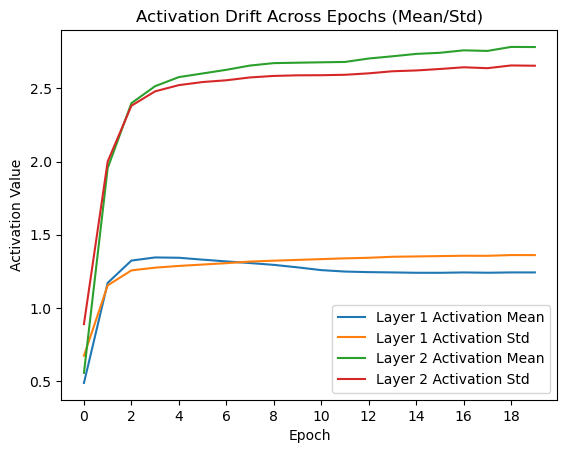

In [127]:
plt.plot(l1_epoch_means, label="Layer 1 Activation Mean")
plt.plot(l1_epoch_stds, label="Layer 1 Activation Std")
plt.plot(l2_epoch_means, label="Layer 2 Activation Mean")
plt.plot(l2_epoch_stds, label="Layer 2 Activation Std")
plt.title("Activation Drift Across Epochs (Mean/Std)")
plt.xticks([i for i in range(epochs) if i % 2 == 0])
plt.xlabel("Epoch")
plt.ylabel("Activation Value")
plt.legend()
plt.show()

### 1.6. per neuron activation mean

In this section, we track the mean post-ReLU activation of each neuron across training epochs. This captures how often and how strongly each neuron is actively contributing to the network’s computation (as opposed to being suppressed by the nonlinearity).
One question is whether the neurons with high activations (e.g. Neuron 2 in Layer 1 and Layer 2) represent truly useful features — or whether they dominate computation and hinder model performance. 

Conversely, neurons with low or highly sporadic activations could be dead, selective, or redundant.
This leads to several questions:

- Are high-activation neurons truly important for prediction, or just overactive?
- Do they participate in superposition, encoding multiple overlapping features?
- How class-specific are these activation patterns?

In [131]:
l1_activations_over_epochs = [torch.cat(l1_activations[epoch], dim=0) for epoch in range(epochs)] # shape: [60000, 32]
l2_activations_over_epochs = [torch.cat(l2_activations[epoch], dim=0) for epoch in range(epochs)] # shape: [60000, 16]

In [133]:
l1_per_neuron_mean_over_epochs = torch.stack([l1_activations_over_epochs[epoch].mean(dim=0) for epoch in range(epochs)]) # shape: [20, 32]
l2_per_neuron_mean_over_epochs = torch.stack([l2_activations_over_epochs[epoch].mean(dim=0) for epoch in range(epochs)]) # shape: [20, 16]

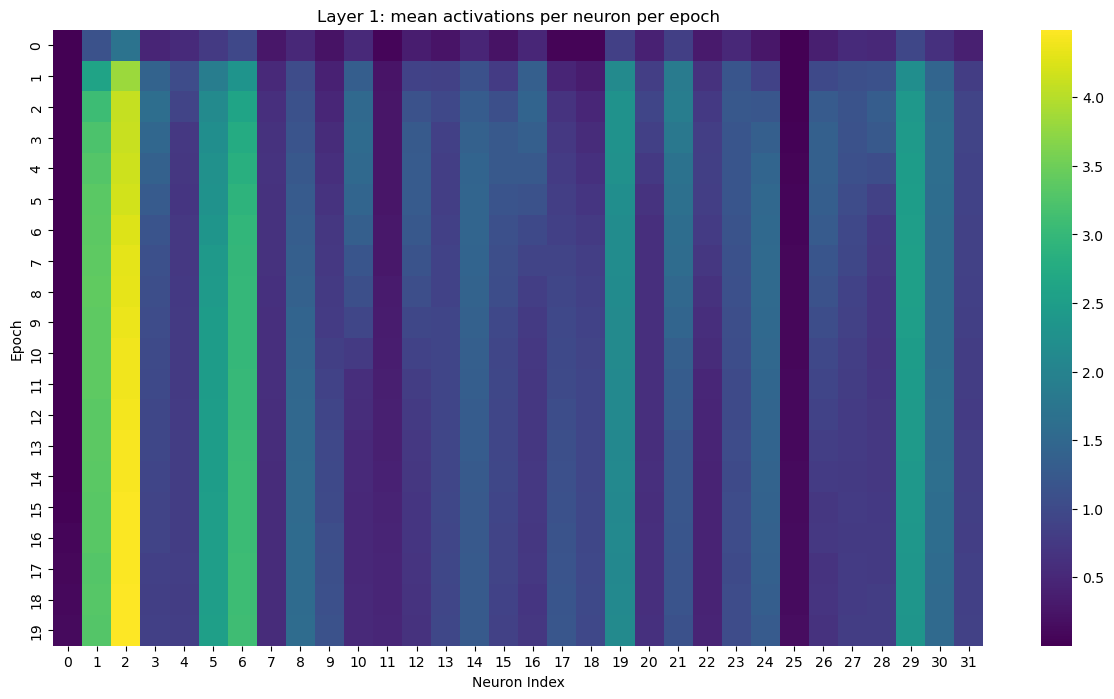

In [135]:
import seaborn as sns

plt.figure(figsize=(15,8))
sns.heatmap(l1_per_neuron_mean_over_epochs, cmap="viridis", xticklabels=True, yticklabels=True)
plt.xlabel("Neuron Index")
plt.ylabel("Epoch")
plt.title("Layer 1: mean activations per neuron per epoch")
plt.show()

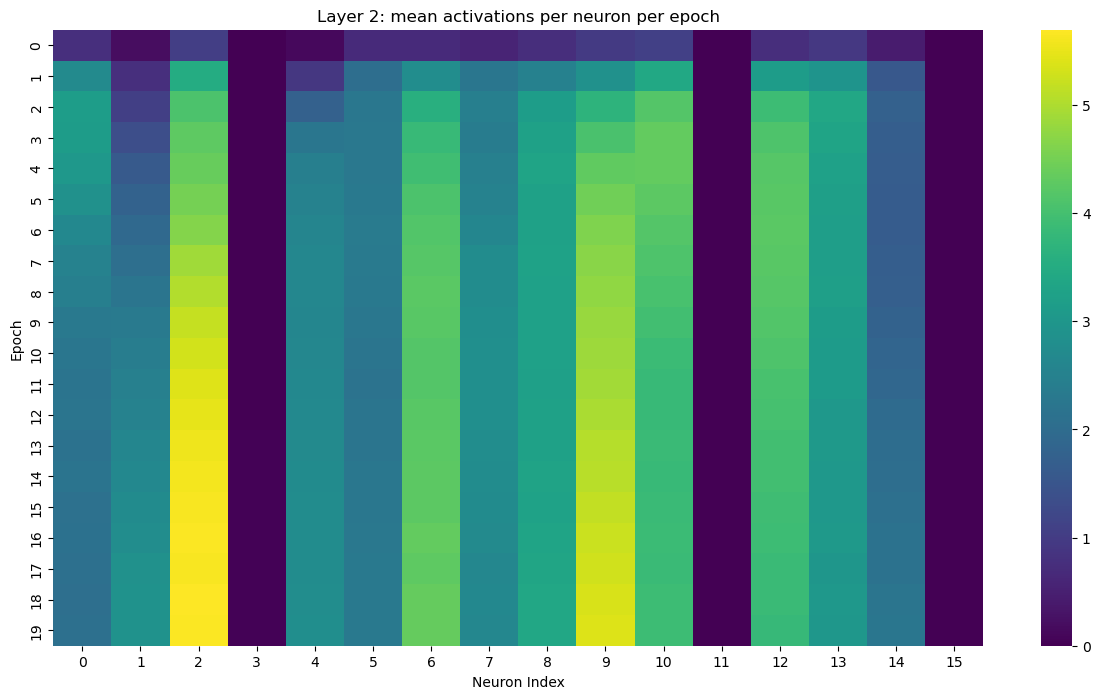

In [77]:
plt.figure(figsize=(15,8))
sns.heatmap(l2_per_neuron_mean_over_epochs, cmap="viridis", xticklabels=True, yticklabels=True)
plt.xlabel("Neuron Index")
plt.ylabel("Epoch")
plt.title("Layer 2: mean activations per neuron per epoch")
plt.show()

---

## Section 2: Post-training interpretability

We now turn our attention to the model after training and trying to interpret some of the behavior based on internal representations. 

### 2.1. activation/gradient tracking in penultimate layer
In this section we run our model on the test data, gathering class based activations/gradients. Our goal here is to understand roughly what the neurons are responding to. 

In [138]:
model.eval()
hook = ActivationAndGradientHook(model.relu2)
hook.register()

gradients_by_class = defaultdict(list) 
activations_by_class = defaultdict(list)


for x, y in test_dataset:
    model.zero_grad()
    hook.clear()

    out = model(x)
    loss = loss_fn(out, torch.tensor([y]))
    loss.backward()

    act = hook.activations[0].squeeze(0).detach()
    activations_by_class[y].append(act)

    grad = hook.activations[0].grad.squeeze(0).detach()
    gradients_by_class[y].append(grad)

hook.remove()

In [140]:
mean_grads_by_class = {}
mean_acts_by_class = {}

for i in range(10):
    mean_grads_by_class[i] = torch.stack(gradients_by_class[i]).mean(dim=0)
    mean_acts_by_class[i] = torch.stack(activations_by_class[i]).mean(dim=0)

In [142]:
for i in range(10):
    grad_vals, grad_idxs = torch.topk(mean_grads_by_class[i], k=3)
    act_vals, act_idxs = torch.topk(mean_acts_by_class[i], k=3)
    
    print(f"Class {i}:")
    print(f"  GRADS: Neurons {grad_idxs.tolist()}")
    print(f"  ACTS:  Neurons {act_idxs.tolist()}\n")

Class 0:
  GRADS: Neurons [10, 9, 7]
  ACTS:  Neurons [6, 2, 8]

Class 1:
  GRADS: Neurons [2, 7, 6]
  ACTS:  Neurons [0, 9, 10]

Class 2:
  GRADS: Neurons [7, 1, 5]
  ACTS:  Neurons [9, 13, 6]

Class 3:
  GRADS: Neurons [0, 2, 10]
  ACTS:  Neurons [9, 6, 12]

Class 4:
  GRADS: Neurons [9, 6, 14]
  ACTS:  Neurons [2, 8, 5]

Class 5:
  GRADS: Neurons [1, 2, 0]
  ACTS:  Neurons [6, 10, 12]

Class 6:
  GRADS: Neurons [12, 5, 14]
  ACTS:  Neurons [8, 2, 10]

Class 7:
  GRADS: Neurons [7, 10, 8]
  ACTS:  Neurons [2, 12, 14]

Class 8:
  GRADS: Neurons [5, 4, 8]
  ACTS:  Neurons [2, 9, 10]

Class 9:
  GRADS: Neurons [13, 10, 4]
  ACTS:  Neurons [2, 9, 12]



One thing we notice immediately here is that neuron 2 has high activations across multiple classes, illustrating why we saw dominant behavior in the previous section. We see the same phenomena for neuron 9, with high activations across multiple classes and a growing activation mean over epochs. 

We investigate this below with some HEATMAPS to verify this, and then try to understand the feature that it is learning. (quickly looking at the classes it seems likely that it has learned to look for some sort of curvature)

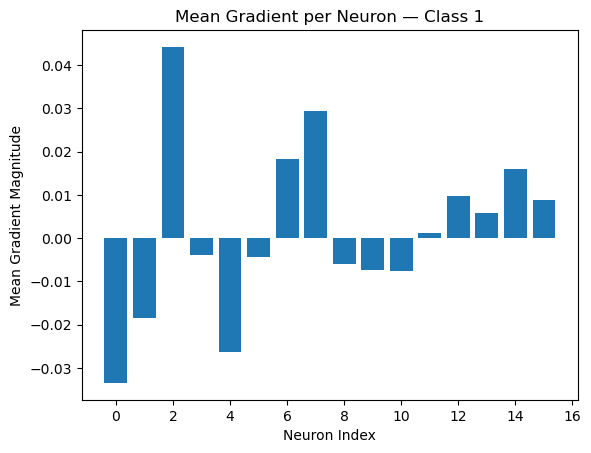

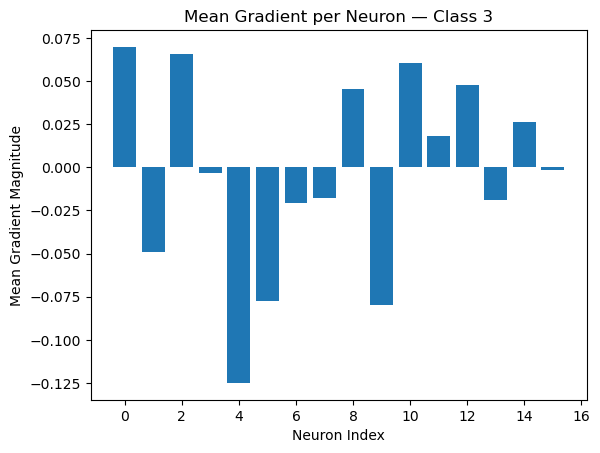

In [86]:
for cls in [1,3]:
    plt.bar(range(len(mean_grads_by_class[cls])), mean_grads_by_class[cls])
    plt.title(f"Mean Gradient per Neuron — Class {cls}")
    plt.xlabel("Neuron Index")
    plt.ylabel("Mean Gradient Magnitude")
    plt.show()

### 2.1. Update
While writing the README for this notebook I realized that the approach above was probably less informative than it could be and rather than computing the gradient with respect to the loss (i.e. across all logits) I should compute the 'class specific' gradients to understand the influence on each class. 
Specifically, rather than computing 

In [147]:
model.eval()
hook = ActivationAndGradientHook(model.relu2)
hook.register()

gradients_by_class = defaultdict(list) 
activations_by_class = defaultdict(list)


for x, y in test_dataset:
    model.zero_grad()
    hook.clear()

    out = model(x)
    out[0][y].backward()

    act = hook.activations[0].squeeze(0).detach()
    activations_by_class[y].append(act)

    grad = hook.activations[0].grad.squeeze(0).detach()
    gradients_by_class[y].append(grad)

hook.remove()

In [149]:
mean_grads_by_class = {}
mean_acts_by_class = {}

for i in range(10):
    mean_grads_by_class[i] = torch.stack(gradients_by_class[i]).mean(dim=0)
    mean_acts_by_class[i] = torch.stack(activations_by_class[i]).mean(dim=0)

In [151]:
for i in range(10):
    grad_vals, grad_idxs = torch.topk(mean_grads_by_class[i], k=3)
    act_vals, act_idxs = torch.topk(mean_acts_by_class[i], k=3)
    
    print(f"Class {i}:")
    print(f"  GRADS: Neurons {grad_idxs.tolist()}")
    print(f"  ACTS:  Neurons {act_idxs.tolist()}\n")

Class 0:
  GRADS: Neurons [6, 12, 13]
  ACTS:  Neurons [6, 2, 8]

Class 1:
  GRADS: Neurons [0, 1, 9]
  ACTS:  Neurons [0, 9, 10]

Class 2:
  GRADS: Neurons [13, 9, 2]
  ACTS:  Neurons [9, 13, 6]

Class 3:
  GRADS: Neurons [9, 4, 5]
  ACTS:  Neurons [9, 6, 12]

Class 4:
  GRADS: Neurons [5, 2, 8]
  ACTS:  Neurons [2, 8, 5]

Class 5:
  GRADS: Neurons [10, 12, 7]
  ACTS:  Neurons [6, 10, 12]

Class 6:
  GRADS: Neurons [8, 7, 13]
  ACTS:  Neurons [8, 2, 10]

Class 7:
  GRADS: Neurons [4, 2, 14]
  ACTS:  Neurons [2, 12, 14]

Class 8:
  GRADS: Neurons [7, 1, 10]
  ACTS:  Neurons [2, 9, 10]

Class 9:
  GRADS: Neurons [7, 14, 9]
  ACTS:  Neurons [2, 9, 12]



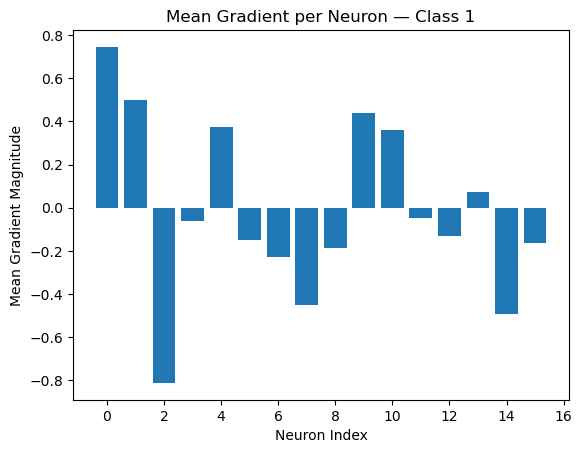

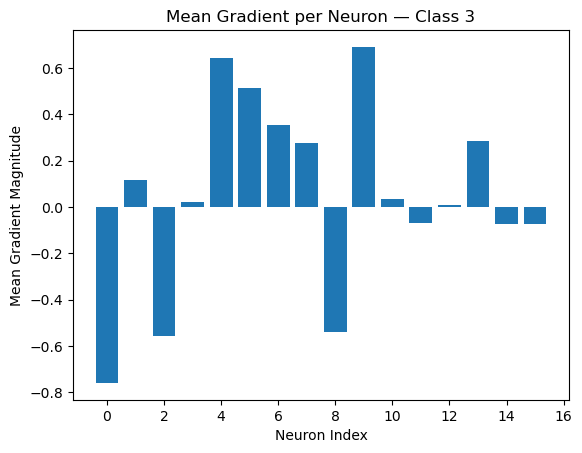

In [154]:
for cls in [1,3]:
    plt.bar(range(len(mean_grads_by_class[cls])), mean_grads_by_class[cls])
    plt.title(f"Mean Gradient per Neuron — Class {cls}")
    plt.xlabel("Neuron Index")
    plt.ylabel("Mean Gradient Magnitude")
    plt.show()

---

## Section 3. Class selectivity score

Our initial approach in this section — ranking neurons by their mean activation for each class — provides some intuition about which neurons are "active" in general. However, it turns out to be somewhat misleading in identifying neurons that are truly specialized.

Using the *class selectivity score* we hope to reveal a more nuanced picture: highlighting neurons whose behavior is class specific, rather than highly active. We compute this class selectivity score for each neuron, $i$. This will compare a neuron's mean activation for a specific class, $\mu_i^{cl}$, to its mean activation across all other classes, $(\mu_i^{cl})^c$:
    $$ S_{i}^{cl} = \frac{\mu_{i}^{cl} - (\mu_{i}^{cl})^c}{\mu_{i}^{cl} + (\mu_{i}^{cl})^c + \epsilon},$$
where $\epsilon$ is a small constant. The goal is to identify neurons that are most responsive to particular classes.

In [1516]:
selectivity_scores = defaultdict(list)
eps = .001

for cl in range(10):
    mu_cl = torch.stack(activations_by_class[cl]).mean(dim=0)
    complement_list = torch.stack([torch.stack(activations_by_class[i]).mean(dim=0) for i in range(10) if i!=cl])
    for i in range(len(mu_cl)):
        other_mu = (sum(complement_list[j][i] for j in range(len(complement_list)))/len(complement_list))
        select_score = (mu_cl[i] - other_mu)/(mu_cl[i] + other_mu + eps)
        selectivity_scores[cl].append(select_score)

In [1520]:
print('Class Selectivity Scores (top 3)')
print('--------------------------------')
for cl in range(10):
    val, ind = torch.topk(torch.stack(selectivity_scores[cl]), k=3)
    print(f'  Class {cl}:   Neurons {ind.tolist()}')

Class Selectivity Scores (top 3)
--------------------------------
  Class 0:   Neurons [6, 8, 12]
  Class 1:   Neurons [0, 3, 1]
  Class 2:   Neurons [15, 13, 9]
  Class 3:   Neurons [4, 6, 5]
  Class 4:   Neurons [5, 2, 8]
  Class 5:   Neurons [3, 7, 6]
  Class 6:   Neurons [8, 13, 10]
  Class 7:   Neurons [14, 4, 12]
  Class 8:   Neurons [7, 0, 1]
  Class 9:   Neurons [14, 5, 7]


#### Some Observations:

- Neuron 2, which ranked highly across classes in the mean activation metric, does not appear in the selectivity rankings for any class! This suggests it's simply broadly active, maybe detecting shared features (e.g. edges, curves) that are useful across classes. We do see that it ranks as the second most selective neuron for class but that is the only appearance in the top 3 for any class.

- Neuron 15 is highly selective for class 2, yet earlier plots suggested it was extremely inactive (nearly dead). We suspect that this neuron might be a 'specialist', activating only for a small subset of inputs — could it only activate for a very specific feature of the digit 2? We explore this further below.
- Neuron 14 is highly selective for both class 7 and class 9. This could mean several things:
    - It may encode a shared visual substructure (e.g., the right-hand vertical stroke or angled top).
    - It may represent a case of superposition, where different features are entangled within the same neuron and used differently depending on context.
    - Alternatively, this could reflect a representation failure — perhaps the model struggles to fully distinguish classes 7 and 9 internally.
 
      
We’ll investigate both neurons 14 and 15 further in the following sections using visualization and ablation.

---

## Section 4. Causal Intervention / Ablation
In this section we dive into the neuron analysis a bit further to extract more information from this network. Specifically, we focus on the second hidden layer and try to understand how important individual neurons are to the accuracy of the model. We do this by using ablation and scaling to see how the accuracy of the model changes under these operations. While we run this (offline) for each neuron we focus here on a select few to highlight some of the tools/visualizations that we hope to use in other projects. 

### Section overview:
This section of the notebook is a little unweildy, but I left it most raw to walk a reader through the chain of thought we had during this experiment. As such, we will highlight some of the sections here to make what follows a bit easier to digest:

- First we wanted to understand the classes 7 and 9 through the eyes of neuron 14 (it was highly selective for these two classes)
    - We start by analyzing class based accuracy of the model without intervention
    - then we test the class accuracy after ablation (zeroing out the activation of neuron 14)
    - Finally we test the class accuracy after inflating the activation of neuron 14
    - We summarize the results here:
      | Scaling Factor   |   Class 7 accuracy  |  Class 9 accuracy  |
      | :--------------: | :-----------------: | :----------------: |
      |        1.0       |        94.46%       |         93.26%     |
      |        0.0       |        81.61%       |         53.32%     |
      |        3.0       |        96.30%       |         97.22%     |
        - Clearly, this neuron plays an important role in the models accuracy on these classes, and the affect under extreme scaling (20x) shows that this increase seems to be monotonic
          
    - Next we test the affect of this scaling on the logits: specifically we run through linear sequence of 50 scales between 0 (ablation) and 3 (to exaggerate the affect), ```torch.linspace(0,3, 50)```, and record the affect on the logits in the output of the model. We see
        - an increase in logits for classes 2,5,7,9
        - no noticable change to the logit for class 3
        - a decrease in the logits for the remaining classes

- Next, we combine and generalize these ideas a bit. We use the linspace scaling to study how changing the activation of neuron 7 (highly selective for class 8) affect the models accuracy on all the classes. Interestingly, ablation drops accuracy on class 8 to around 55% but it also drops accuracy on class 9 more, to about 23%.
    - This suggests that accuracy on class 9 might be primarily influenced by the combination of neurons 7 AND 14
    - We visualize where the failures occur using a heatmap representing the confusion matrix: for example the entry in the intersection of the 10th row and 8th column of this 10x10 grid will show us (via color intensity) how frequently a 9 is mislabeled as a 7.
 
- We then create a helper function that will generate all of the above for us: ```analyze_neuron```

In [316]:
indices = (test_dataset.targets == 7) | (test_dataset.targets == 9)

test_79 = [(img, label) for img, label in zip(test_dataset.data[indices], test_dataset.targets[indices])]

### 4.0. Testing the model on classes 7 and 9

In [1607]:
correct = defaultdict(int)
total = defaultdict(int)

with torch.no_grad():
    for x,y in test_79:
        out = model(x.float())
        pred = torch.argmax(out, dim=1).item()
        if pred == y:
            correct[y.item()] += 1
        total[y.item()] += 1

for cl in total:
    print(f'Models accuracy on class {cl} is {correct[cl]/total[cl] * 100:.2f}%') 

Models accuracy on class 7 is 94.46%
Models accuracy on class 9 is 93.26%


#### 4.0.1. Scaling of neuron 14

In [326]:
# Change the scale of neuron 14 to see how the accuracy of the model on classes 7 and 9 change
# Ablation yields (81% on class 7 and 53% on class 9)
scale = 3.0

correct = defaultdict(int)
total = defaultdict(int)

with torch.no_grad():
    for x,y in test_79:
        out1 = model.linear1(x.view(1,-1).float())
        act1 = model.relu1(out1)
        out2 = model.linear2(act1)
        act2 = model.relu2(out2)

        # Scaling Neuron 14 in layer 2
        act2[0][14] *= scale

        out = model.output(act2)

        pred = torch.argmax(out, dim=1).item()
        if pred == y:
            correct[y.item()] += 1
        total[y.item()] += 1

for cl in total:
    print(f'Models accuracy on class {cl} is {correct[cl]/total[cl] * 100:.2f}%') 

Models accuracy on class 7 is 96.30%
Models accuracy on class 9 is 97.22%


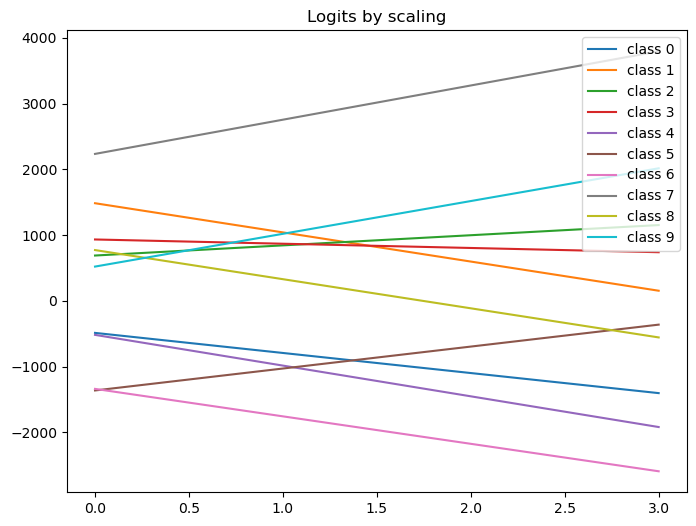

In [1637]:
logits_tensor = torch.stack(logits_per_scale)

plt.figure(figsize=(8,6))
for i in range(10):
    plt.plot(scales, logits_tensor[:, i], label=f"class {i}")
#plt.plot(scales, logits_tensor[:, 2], label="logit for class 2")
plt.title('Logits by scaling')
plt.legend()
plt.show()

### 4.1. Generalizing to other neurons

In [337]:
model.eval()

scales = torch.linspace(0, 3, 20)
accuracy_per_scale = defaultdict(list)

neuron = 7

for scale in scales:
    correct = defaultdict(int)
    total = defaultdict(int)

    with torch.no_grad():
        for x,y in test_dataset:
            out1 = model.linear1(x.view(1,-1).float())
            act1 = model.relu1(out1)
            out2 = model.linear2(act1)
            act2 = model.relu2(out2)
    
            act2[0][neuron] *= scale
            out = model.output(act2)
            
            pred = torch.argmax(out, dim=1).item()
            if pred == y:
                correct[y] += 1
            total[y] += 1


    for cls in total:
        acc = 100 * correct[cls] / total[cls]
        accuracy_per_scale[cls].append(torch.tensor(acc))


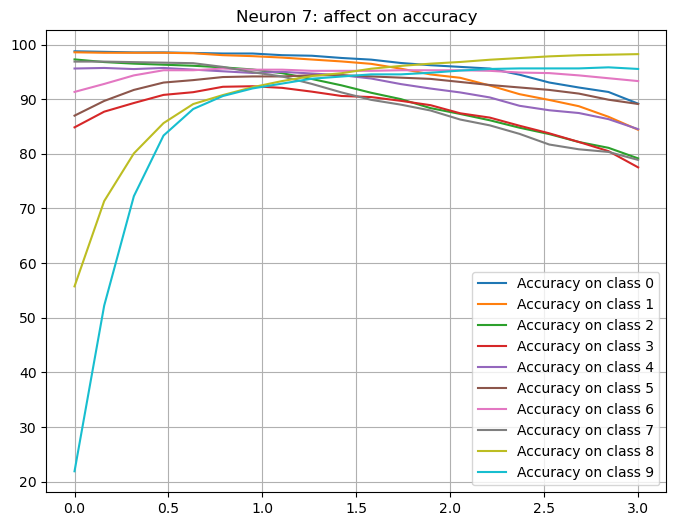

In [339]:
plt.figure(figsize=(8,6))
for cl in range(10):
    plt.plot(scales, torch.stack(accuracy_per_scale[cl]), label=f"Accuracy on class {cl}")
plt.title(f'Neuron {neuron}: affect on accuracy')
plt.legend()
plt.grid(True)
plt.show()

### 4.2. Confusion Matrix
Next, we try to understand what is going on when we scale neurons. Obviously, we see an increase in accuracy for some classes and a decrease in other, so what is happening? We look at the confusion matrix, which is a 10x10 matrix whose $(i,j)$ entry is the number of times that the digit $i$ is labeled as $j$. We visualize this with heatmaps. 

In [405]:
confusion_matrix_baseline = torch.zeros([10,10])
model.eval()

neuron = 7

for x,y in test_dataset:
    out1 = model.linear1(x.view(1,-1).float())
    act1 = model.relu1(out1)
    out2 = model.linear2(act1)
    act2 = model.relu2(out2)
    act2[0][neuron] *= 1
    out = model.output(act2)
    
    pred = torch.argmax(out, dim=1).item()
    
    confusion_matrix_baseline[y, pred] += 1

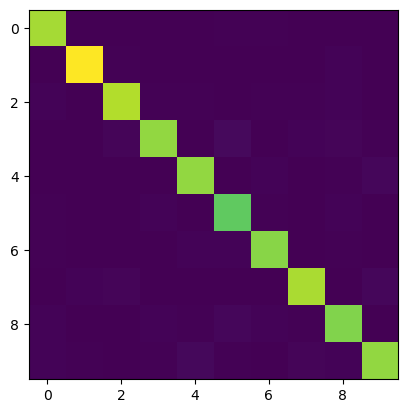

In [494]:
# this is the baseline... there should be little 'confusion' here, so we expect primarily the diagonal to light up
plt.imshow(confusion_matrix_baseline)
plt.show()

In [450]:
confusion_matrix_ablation = torch.zeros([10,10], dtype=int)
model.eval()

neuron = 7

for x,y in test_dataset:
    out1 = model.linear1(x.view(1,-1).float())
    act1 = model.relu1(out1)
    out2 = model.linear2(act1)
    act2 = model.relu2(out2)
    act2[0][neuron] *= 0
    out = model.output(act2)
    
    pred = torch.argmax(out, dim=1).item()
    
    confusion_matrix_ablation[y, pred] += 1

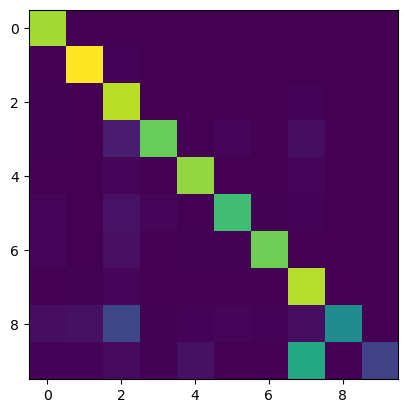

In [492]:
# This is the confusion matrix under ablation. It will show where the model mislabels classes
plt.imshow(confusion_matrix_ablation)
plt.show()

Under ablation:
    A 9 was misclassified as a 7 66.90% of the time
    An 8 was misclassified as a 2 25.05% of the time


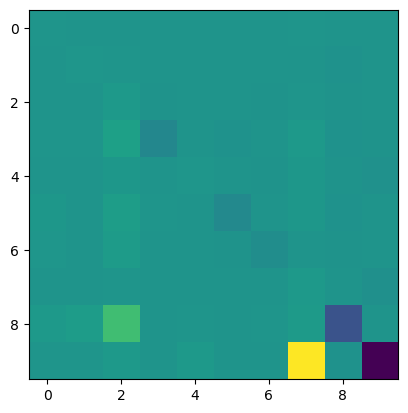

In [500]:
# Now, we look at the difference of these two confusion matrices to see where the majority of the errors lie
print('Under ablation:')
print(f'    A 9 was misclassified as a 7 {confusion_matrix_ablation[9,7].item()/confusion_matrix_ablation.sum(dim=1)[9].item()*100:.2f}% of the time')
print(f'    An 8 was misclassified as a 2 {confusion_matrix_ablation[8,2].item()/confusion_matrix_ablation.sum(dim=1)[8].item()*100:.2f}% of the time')
plt.imshow(confusion_matrix_ablation - confusion_matrix_baseline)
plt.show()

#### Generalizing via a helper function (run some examples for yourself! It is quite fun to see the output)

In [544]:
def analyze_neuron(
    model, 
    neuron_idx = 0,
    test_data = test_dataset, 
    scaling_interval = (0, 3.0), 
    steps = 30
    ):

    """ 
    Input: 
        model: some model... for now, it is just for our model defined above
        neuron_idx: the index of the neuron you want to study
        test_data: the dataset you want to analyze behavior wrt
        scaling_interval: the interval you want to sample scales from (scale * output_of_neuron_idx)
        steps: number of scales you want to draw from the interval

    Output: a tuple of
        analyze_neuron[0]: Class based accuracy plot
        analyze_neuron[1]: Confusion matrix under ablation (scale=0)
        analyze_neuron[2]: Baseline confusion matrix (scale=1)
        analyze_neuron[3]: Confusion matrix under interval max (scale=scaling_interval[1])
    """
    
    scales = torch.linspace(scaling_interval[0], scaling_interval[1], steps)
    if 1 not in scales:
        scales = torch.cat((scales, torch.tensor([1])))
        scales = torch.sort(scales).values

    accuracy_per_scale = defaultdict(list)
    
    neuron = neuron_idx

    confusion_matrix_ablation = torch.zeros((10,10))
    confusion_matrix_baseline = torch.zeros((10,10))
    confusion_matrix_max = torch.zeros((10,10))
    
    for scale in scales: 
        correct = defaultdict(int)
        total = defaultdict(int)
        with torch.no_grad():
            for x,y in test_dataset:
                out1 = model.linear1(x.view(1,-1).float())
                act1 = model.relu1(out1)
                out2 = model.linear2(act1)
                act2 = model.relu2(out2)
        
                act2[0][neuron] *= scale
                out = model.output(act2)
                
                pred = torch.argmax(out, dim=1).item()
                if pred == y:
                    correct[y] += 1
                total[y] += 1

                if scale == 0:
                    confusion_matrix_ablation[y][pred] += 1
                elif scale == 1:
                    confusion_matrix_baseline[y][pred] += 1

                elif scale == scaling_interval[1]:
                    confusion_matrix_max[y][pred] += 1
                
        for cls in total:
            acc = 100 * correct[cls] / total[cls]
            accuracy_per_scale[cls].append(torch.tensor(acc))

    plt.figure(figsize=(8,6))
    for cl in range(10):
        plt.plot(scales, torch.stack(accuracy_per_scale[cl]), label=f"Accuracy on class {cl} per scale")
    plt.title(f'Neuron {neuron}: affect on accuracy')
    plt.legend()
    plt.grid(True)
            
    return (plt, confusion_matrix_ablation, confusion_matrix_baseline, confusion_matrix_max)

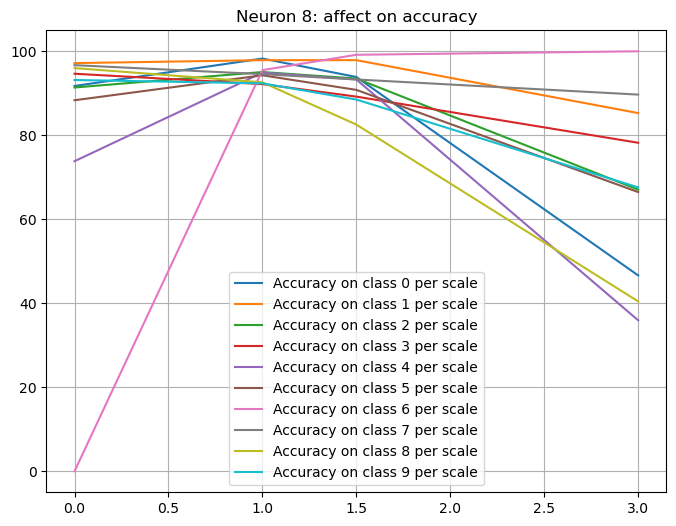

In [1343]:
neuron_idx = 8
model_analysis = analyze_neuron(model, neuron_idx, test_dataset, (0,3), 3)

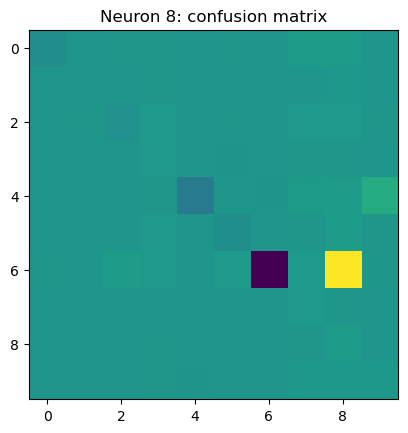

In [548]:
plt.imshow(model_analysis[1] - model_analysis[2])
plt.title(f'Neuron {neuron_idx}: confusion matrix')
plt.show()

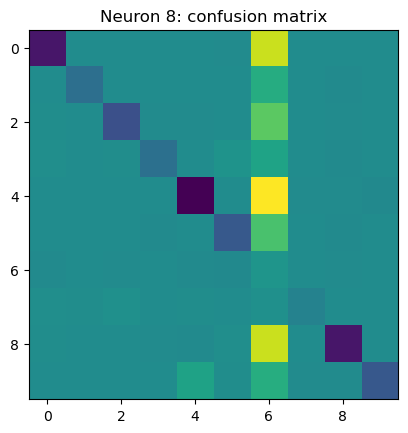

In [552]:
plt.imshow(model_analysis[3]-model_analysis[2])
plt.title(f'Neuron {neuron_idx}: confusion matrix')
plt.show()

### 4.3. Conclusion
We output various plots in this section, some of which we explain and outline in the README of this MLP section. What we left here at the end however was not explicitly mentioned so we outline it here. 
>#### *Neuron 8*
>- Neuron 8 appears to be a bottleneck neuron (neuron 8) for the class 6:
    - when ablated the accuracy drops to 0% on this class, signalling that this neuron is relied upon heavily for the correct classification. 
>- It also appears to be an attracting neuron when overactivated:
    - scaling (by 3) causes the model to misclassify a wide range of digits as 6.
>- Interpretation: 
    - we suspect that neuron 8 is likely detecting some shared feature of 6,8: such as a bottom-left curve, lower loop, etc.
    - given that 4 is frequenly confused with 6 when over-activated (last plot) we might also guess that it is detecting a shared feature of 4 and 6 OR a feature that is not present in most 4s but becomes falsely identified in the extreme activation.
 
This is just one neuron (others are discussed in the README but you should also explore this for yourself!) but I think it shows that even in this small MLP single neurons can play large roles and careful tuning is required to clearly define class boundaries. 

In the next section we analyze these boundaries a bit using the dimensionality reduction methods PCA/UMAP discussed in the previous notebook. (AND in the section after that we try to analyze the features that these neurons are actually detecting through *saliency* and *'one-hot' perturbation* plots)

---

## Section 5: PCA/UMAP on Neuron Subspaces

In the last notebook we looked at the PCA/t-SNE/UMAP plots for the full (16-dimensional) activation space of layer 2. In this section we want to do something a bit different. Since we now know the neurons that are highly selective for all classes (Selectivity section) we restrict our attention to these neurons to see if we get a very different picture. 

> The experiment:
> 1) Select Neuron from layer 2:
>     - For each class consider the highly selective neurons (we computed this in section 3)
>     - form the union of some of these nuerons (we consider a proper subset of all 16 neurons so we are doing something non-trivial)
> 2) Gather activations:
>     - run through our ```test_dataset``` and gather the activations of only these neurons (the result is some vector in the 'selectivity subspace')
> 3) Apply dimensionality reduction:
>     - Run PCA
>     - run UMAP
>     - note: t-SNE would not run in the notebook last time so we just focus on the two extremes
The goal is to see whether some proper subset of the activation space is enough to separate the data by class... this would suggest that only a few neurons are sufficient to distinguish the classes.

Given that the last PCA/UMAP experiment showed that points in the activation space were not always well separated we can't hope for them to be in this case but we are interested in the experiment nonetheless as ultimately we want to bridge from this neuron by neuron analysis to the more interesting question of interpreting 'activation subspaces' or some linear combinations of neurons. This experiment is motivated by various lines of questioning in mechanistic interpretability: such as 'Toy models of superposition' from Anthropic. 

***Alright, already... Lets get into it!***

***Okay**... one more note. There are various options for the construction of subspaces*
>1) Per-class subspace:
    - Fix a class, $cl$
    - select the top $k$ selective neurons
    - project all inputs onto that subspace
    - examine clustering (any obvious features encoded in this subspace?)
    - repeat
>
>2) Something similar to the above but maybe with mixed classes and compare with $k$ random neurons: is there a noticable difference?
>3) Construct some 'feature' specific subspace:
    - Hand pick a subset of ~5-8 neurons from the experiments above
    - perform the reduction
    - see how minimal a subset we can pick while retaining some of the separation that we saw in the previous notebook. 

### 5.1. basic function and example with class 0

In [1029]:
# Let's write a couple simple functions to make the experimentation a bit more clean
from sklearn.decomposition import PCA
from umap import UMAP


def get_subspace_activations(model, dataloader, neuron_indices):
    model.eval()
    neuron_indices = torch.tensor(neuron_indices)
    
    subspace_activations = []
    labels = []
    
    with torch.no_grad():
        for xs,ys in test_loader:
            out1 = model.linear1(xs.view(xs.size(0), -1).float())
            act1 = model.relu1(out1)
            out2 = model.linear2(act1)
            act2 = model.relu2(out2)
    
            # Gather subspace activations
            selected = act2[:, neuron_indices]
            subspace_activations.append(selected)
            labels.append(ys)
    
    # Concatenate across batches
    X = torch.cat(subspace_activations, dim=0).numpy()
    Y = torch.cat(labels, dim=0).numpy()

    return X, Y



def subspace_projection(X,Y, method="pca", title="Neuron Subspace Projection"):
    if method == "pca":
        proj = PCA(n_components=2).fit_transform(X)
        xlabel = "PC1"
        ylabel = "PC2"
    elif method == "umap":
        proj = UMAP(n_components=2).fit_transform(X)
        xlabel = "U1"
        ylabel = "U2"
    else:
        raise ValueError("method must be 'pca' or 'umap'.")
    
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(proj[:,0], proj[:,1], c=Y, cmap="tab10", s=7, alpha=0.5)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.grid(True)
    return plt.show(), proj

### 5.1.2. Class 0 examples

In [1457]:
# selecting a subset of the selective neurons from class 0
val, idx = torch.topk(torch.tensor(selectivity_scores[3]), k=5)
selectivity_subset = idx.tolist()
print(selectivity_subset)

[4, 6, 5, 13, 9]


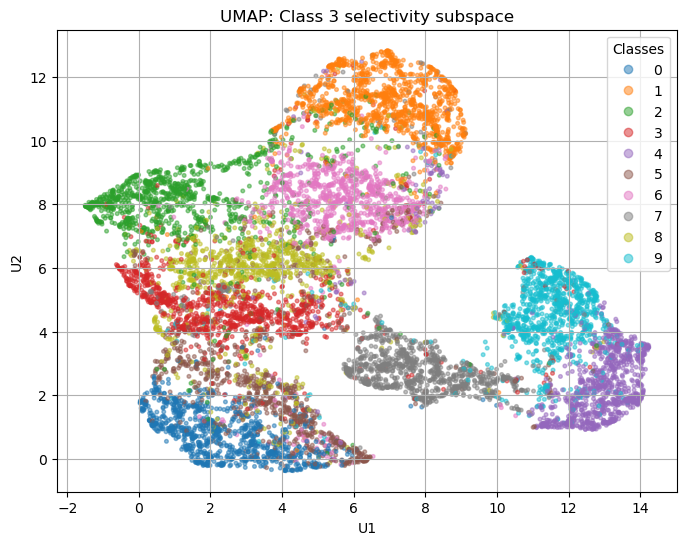

In [1459]:
X, Y = get_subspace_activations(model, test_loader, selectivity_subset)
plot, proj = subspace_projection(X,Y, method='umap', title="UMAP: Class 3 selectivity subspace")

In [1045]:
random_subset = torch.randperm(16)[:5].tolist()
print(random_subset)

[12, 7, 10, 15, 1]


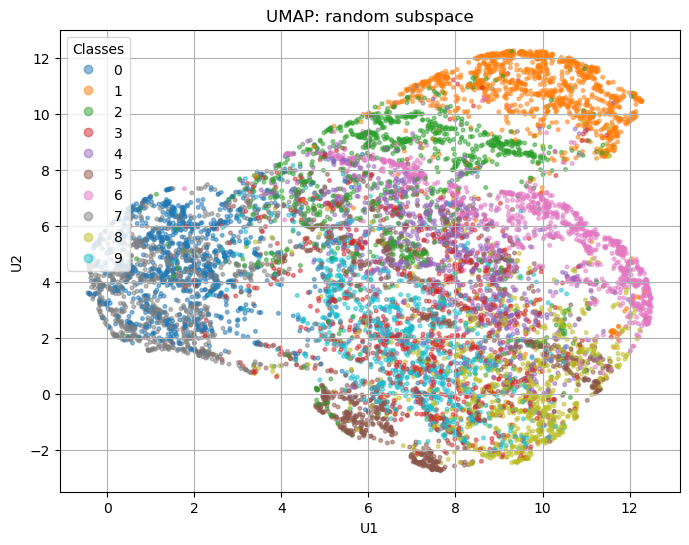

In [1047]:
X, Y = get_subspace_activations(model, test_loader, random_subset)
plot, proj = subspace_projection(X,Y, method='umap', title="UMAP: random subspace")

### 5.2. Quick summary/follow ups
Changing the class has a fairly dramatic affect on the quality of the plot, showing that certain class selective neuron subsets are better at preserving the geometry of the activation space than others. That said, we are analyzing this visually and should rather try to be quantify how good or bad a given subset is at preserving this clustering. That is what we do in the next section.

> Note to self: It would be interesting to animate a plot as one prunes neurons from the layer, in some sense visualizing the degradation of the geometry. 

## 6. Neuron pruning and subspace separation
> ***Question**: How well do different subsets of neurons preserve the structure of the models activation space?*

In particular, we wish to quantify the class separation in low-dimensional subspaces defined by subsets of neurons. 

The methods we explored above - including class selectivity, ablation, and the effect of activation scaling - showed that certain neurons were redundant/unimporant (neuron 15), while others served a critical role (neuron 0 for class 1 and neuron 8 for class 6). So, the question is: can we prune neurons based on certain interpretability informed metrics without collapsing the geometry of the activation space too much. 

To test this we would like to compare various neural subsets (e.g. randomly choosen, based on selectivity scores, based on high mean activation, or hand selected from the scaling results)
- Generate subsets and determine activation subspace
- apply dimensionality reduction (PCA/UMAP)
- Use **silhouette score** to measure class cluster separation and compare. 


### 6.1. Silhouette score

The silhouette score quantifies how well a data point fits within its assigned cluster compared to neighboring clusters. It’s often used to evaluate clustering quality, especially in reduced-dimensional spaces like PCA or UMAP projections. One place to look for an overview of this technique is [Wikipedia](https://en.wikipedia.org/wiki/Silhouette_(clustering)). 
For a given point, $p$, we define:
- $a(p)$: average distance to other points in the same cluster (this is called *cohesion*)
- $b(p)$: average distance to the points in the nearest neighboring cluster (this is called *separation*)
and then the silhouette score is given as:
    $$ s(p) = \frac{b(p) - a(p)}{\max \{a(p), b(p)\}} $$
>Notes:
> - The score ranges from:
>   -  1 (well clustered and separated from neighbors)
>   -  0 (on the boundary between clusters)
>   -  <0 (likely misclassified or overlapping)
> - This is computationally expensive if we do this naively: for example, if there are $N$ data points then the pairwise distances scale as $\mathcal{O}(N^2)$. i.e. to do this for every point in our dataset we would be doing $\approx 100,000,000$ distance computations.
>   - Luckily, we can rely on vectorized oprations and other optimization methods by outsourcing it to: ```sklearn.metrics.silhouette_score``` (at least for our relatively small dataset)
> - What do YOU mean by distance? When we discuss distance we typically (thinking of euclidean space) define distance as the length of the "straight line" connecting the data points but we need not use this notion of distance... i.e. there are options! For now, we just use euclidean and call `sklearn` but there is a rabbit hole if you want to explore! 

### 6.2. The silhouette score

In [1575]:
from sklearn.metrics import silhouette_score
# score = silhouette_score(X, Y, metric='euclidean')

In [1301]:
# To make what follows more clean/clear we just use this little helper function.
import warnings

def test_silhouette_score(model, dataset, subset):
    ''' 
    INPUT: 
        - model
        - dataset
        - subset of neurons
    OUTPUT: 
        the silhouette score of both 
        - full neural subspace
        - UMAP projection space.
    '''
    
    X, Y = get_subspace_activations(model, dataset, subset)
    
    # UMAP can run in parellel so it gets mad when we try to fix a seed (we are worried about reproducibility, not determinism, so we ignore)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        proj = UMAP(n_components=2, random_state=314).fit_transform(X)

    full_score = silhouette_score(X, Y, metric='euclidean')
    proj_score = silhouette_score(proj, Y, metric='euclidean')

    return full_score, proj_score

#### 6.2.1. Baseline
First, we compute the silhouette score for:
- the entire activation space (16 dimensional)
- the projected space (UMAP)

In [1303]:
full_score, proj_score = test_silhouette_score(model, test_loader, [i for i in range(16)])

print('Silhouette score for full layer')
print(f"Neurons: ALL | Full: {full_score:.2f} | UMAP: {proj_score:.2f}")

Silhouette score for full layer
Neurons: ALL | Full: 0.23 | UMAP: 0.54


#### 6.2.2. Class selective (5 neuron) subspace
Here we calculate the silhouette score for a subset of 5 selective neurons. For each class we compute:
- selectivity subset (top 5 neurons)
- print silhouette score for (full) activation subspace
- print silhouette score for the (UMAP) projection space 

In [1496]:
print('Silhouette score based on top 5 selective neurons per class')
print('-----------------------------------------------------------')
for cl in range(10):
    val, idx = torch.topk(torch.tensor(selectivity_scores[cl]), k=5)
    selectivity_subset = idx.tolist()
    
    full_score, proj_score = test_silhouette_score(model, test_loader, selectivity_subset)
    
    print(f"Class {cl} | Neurons: {selectivity_subset} | Full: {full_score:.2f} | UMAP: {proj_score:.2f}")

Silhouette score based on top 5 selective neurons per class
-----------------------------------------------------------
Class 0 | Neurons: [6, 8, 12, 2, 11] | Full: 0.12 | UMAP: 0.10
Class 1 | Neurons: [0, 3, 1, 4, 13] | Full: 0.06 | UMAP: 0.08
Class 2 | Neurons: [15, 13, 9, 6, 10] | Full: 0.12 | UMAP: 0.15
Class 3 | Neurons: [4, 6, 5, 13, 9] | Full: 0.14 | UMAP: 0.20
Class 4 | Neurons: [5, 2, 8, 10, 7] | Full: 0.12 | UMAP: 0.15
Class 5 | Neurons: [3, 7, 6, 12, 10] | Full: 0.09 | UMAP: 0.10
Class 6 | Neurons: [8, 13, 10, 7, 2] | Full: 0.14 | UMAP: 0.21
Class 7 | Neurons: [14, 4, 12, 0, 2] | Full: 0.11 | UMAP: 0.11
Class 8 | Neurons: [7, 0, 1, 10, 3] | Full: 0.08 | UMAP: 0.07
Class 9 | Neurons: [14, 5, 7, 0, 2] | Full: 0.14 | UMAP: 0.19


#### 6.2.3. Random (5 neuron) subsets
To test the selectivity subset performance we compute randomly selected neurons
- pick 5 neurons at random
- compute the 5D ('full') silhouette score
- compute the 2D (UMAP) projection silhouette score

In [1297]:
# For selectivity neurons of randomly selected neurons
# we compute the average selectivity score over N trials of 5 randomly chosen neurons 

N = 30
random_trial_selectivity_scores = torch.tensor([0.0,0.0])

for trial in range(N):
    random_subset = torch.randperm(16)[:5].tolist()

    full_score, proj_score = test_silhouette_score(model, test_loader, random_subset)

    random_trial_selectivity_scores += torch.tensor([full_score, proj_score])

average_ss = random_trial_selectivity_scores/N

print(f'Random subset baseline (subset_size = 5, trials = {N})')
print('-----------------------------------------------------')
print(f" Full: {average_ss[0]:.2f} | UMAP: {average_ss[1]:.2f}")

Random subset baseline (subset_size = 5, trials = 30)
-----------------------------------------------------
 Full: 0.08 | UMAP: 0.10


#### 6.2.4. Hand picked 5 neuron subset
Finally, we use what we found in section 4 to hand select 5 neurons

In [1399]:
select_subset = [6, 7, 8, 10, 13]

full_score, proj_score = test_silhouette_score(model, test_loader, select_subset)

print('Silhouette score of hand-picked 5 neuron subset')
print('-----------------------------------------------')
print(f'Neurons: {select_subset} | Full: {full_score:.2f} | UMAP: {proj_score:.2f}')

Silhouette score of hand-picked 5 neuron subset
-----------------------------------------------
Neurons: [6, 7, 8, 10, 13] | Full: 0.19 | UMAP: 0.30


#### 6.2.5. handpicking poor subsets
Using the same analysis we can select poor neuron subsets to get something very bad:

In [1403]:
select_subset = [2, 0, 3, 11, 15]

full_score, proj_score = test_silhouette_score(model, test_loader, select_subset)

print('Silhouette score of hand-picked 5 neuron subset')
print('-----------------------------------------------')
print(f'Neurons: {select_subset} | Full: {full_score:.2f} | UMAP: {proj_score:.2f}')

Silhouette score of hand-picked 5 neuron subset
-----------------------------------------------
Neurons: [2, 0, 3, 11, 15] | Full: -0.04 | UMAP: -0.05


#### 6.2.6. intersection of the selectivity subsets across classes
To end this section we take the neurons that are most selective across classes

In [1540]:
# Experiment: find the top 5 occurance in selective neurons across all classes
selects = {i:0 for i in range(16)}
for cl in range(10):
    val, ind = torch.topk(torch.stack(selectivity_scores[cl]), k=3)
    for num in ind.tolist():
        selects[num] += 1

print(selects)
print(sorted(selects, key=lambda x: selects[x], reverse=True))

{0: 2, 1: 2, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7: 3, 8: 3, 9: 1, 10: 1, 11: 0, 12: 2, 13: 2, 14: 2, 15: 1}
[5, 6, 7, 8, 0, 1, 3, 4, 12, 13, 14, 2, 9, 10, 15, 11]


In [1542]:
select_subset = [5, 6, 7, 8, 0]

full_score, proj_score = test_silhouette_score(model, test_loader, select_subset)

print('Silhouette score of selectivity based 5 neuron subset')
print('-----------------------------------------------------')
print(f'Neurons: {select_subset} | Full: {full_score:.2f} | UMAP: {proj_score:.2f}')

Silhouette score of selectivity based 5 neuron subset
-----------------------------------------------------
Neurons: [5, 6, 7, 8, 0] | Full: 0.17 | UMAP: 0.24


### 6.3. Summary


We began with randomly selecting 5 neurons as a baseline, and find the average silhouette score over 30 experiments to be about 0.08. This is comparable to several class-sective subsets that we sampled. While this is not outstanding, it does show that small subsets can retain some of the geometric information of the data. Interestingly, 
- certain class based subsets perform better: classes 3,6, and 9 score around 0.14.
- a couple of hand selected subsets score ~0.17-0.19
- selecting from the intersection of class selective neurons scores ~0.17 (however, this is quite sensitive to the choice of topk neurons, k=3 scored best in our experiment)

For reference the silhouette score on the entire hidden layer is 0.23 so we recover around 80% of the geometric quality using less than 33% of the neurons.

> This shows that class-selective/interpretable neurons can compress the activaiton space without dramatically affeecting the clustering in the space.

 

NOTE: Since this choice of 5 neurons was, itself, random we now do a quick experiment to see how the number of neurons affects the silhouette score. 

### 6.4. Plotting separation performance (silhouette score) vs size of subset

Here we examine the silhouette score with respect to the size of the neural subset. We compute the score for subspace dimension growing from 2 to 16 (even increments) across three different sets of subspaces:
- class-selectivity-based subsets
- hand selected subsets
- randomly selected subsets. 

In [1622]:
class_selectivity_overlap = [5, 6, 7, 8, 0, 1, 3, 4, 12, 13, 14, 2, 9, 10, 15, 11]
hand_selected_set = [6, 7, 8, 10, 13, 0, 14, 12, 11, 5, 9, 1, 4, 2, 3, 15]

class_selects = []
hand_selects = []
random_selects = []


# number of random samples per step
N = 10

dims = list(range(2,17, 2))

for step in dims:
    # Hand selected subset
    X, Y = get_subspace_activations(model, test_loader, hand_selected_set[:step])
    score = silhouette_score(X, Y, metric='euclidean')
    hand_selects.append(score)

    # Class-selectivity based subset
    X, Y = get_subspace_activations(model, test_loader, class_selectivity_overlap[:step])
    score = silhouette_score(X, Y, metric='euclidean')
    class_selects.append(score)

    # Randomly samples subsets
    random_silhouette_score = 0
        
    for trial in range(N):
        random_subset = torch.randperm(16)[:step].tolist()
    
        X, Y = get_subspace_activations(model, test_loader, random_subset)

        score = silhouette_score(X, Y, metric='euclidean')
        random_silhouette_score += score
    
    random_selects.append(random_silhouette_score/N)


In [1624]:
full_score, proj_score = test_silhouette_score(model, test_loader, [i for i in range(16)])
baseline = [full_score for step in dims]

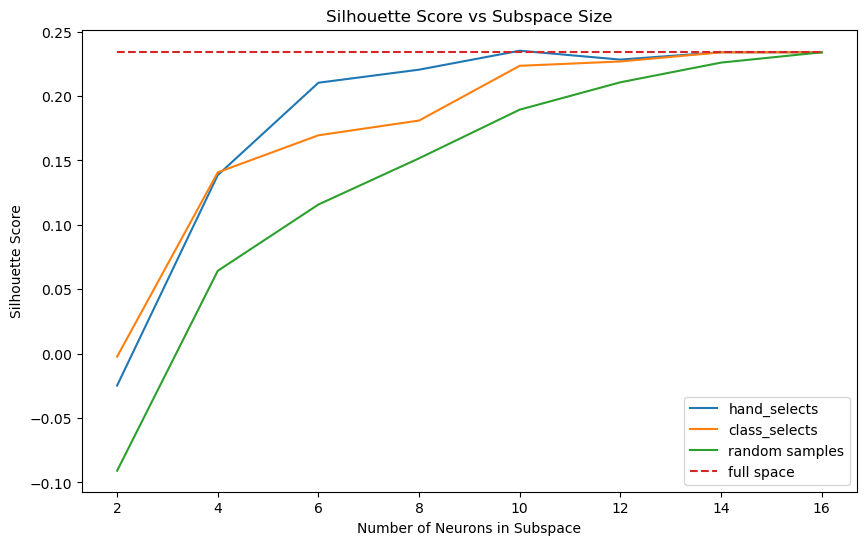

In [1625]:
plt.figure(figsize=(10,6))
plt.plot(dims, hand_selects, label='hand_selects')
plt.plot(dims, class_selects, label='class_selects')
plt.plot(dims, random_selects, label='random samples')
plt.plot(dims, baseline, linestyle='--', label='full space')
plt.title('Silhouette Score vs Subspace Size')
plt.xlabel('Number of Neurons in Subspace')
plt.ylabel('Silhouette Score')
plt.legend()
plt.show()

---

# 7. Activation/Gradient analysis and visualizations

(This section used to be at the beginning but we did some reshuffling... hopefully it still fits in alright)

As a final section we dig a bit into the activation/gradient plots but focus on class based data. Ultimately, we are trying to analyze what a neuron might be looking for given some input, $x$. 
- We start by plotting mean activations of each neuron across classes (we do this for both hidden layers)
- Then, we focus on gradient based salency: for a fixed input we analyze the saliency plot of each neuron to try and understand what features of the input are important to the neuron
- Finally, rather than looking at the neurons response to particular inputs we create a *one-hot perturbation* plot to try and see where the neurons have learned to look. This sort of thing might be more informative in a CNN but the basic idea is to feed the neuron a blank image with 1 pixel turned on, record the activation for that pixel, and reprat for all 784 pixels.

### 7.0 Helper function for plotting heatmaps

In [1639]:
def heatmap(tuple_mean, layer_title):
    plt.figure(figsize=(10,6))
    sns.heatmap(tuple_mean, cmap="viridis", xticklabels=True, yticklabels=True)
    plt.xlabel("Neuron Index")
    plt.ylabel("Class Label")
    plt.title(f"Mean Activations per Class (after {layer_title})")
    plt.show()

### 7.1. Gather activations

The first thing we do is pull out the activations based on class. Note:
> we change the hook in this cell for each of the following cells (plotting the heatmaps)\
> e.g. ```ActivationHook(model.___)``` where ```____ in [output, relu1, relu2]```

In [1649]:
hook = ActivationAndGradientHook(model.relu2)
hook.register()
model.eval()

activations_by_class = defaultdict(list)

for x,y in test_dataset:
    hook.clear()

    _ = model(x)

    acts = hook.activations[0].squeeze().detach()
    activations_by_class[y].append(acts)

hook.remove()

#### 7.1.1. Compute the (per class) mean activation for each neuron

In [1651]:
mean_activations = torch.stack([torch.stack(activations_by_class[cl]).squeeze().mean(dim=0) for cl in range(10)])
mean_activations.shape  # [class, outputs]

torch.Size([10, 16])

### 7.1.2. Quick sanity check...
Our model has been trained to maximize logits on the correct class: we expect the heatmap to be the brightest along the diagonal... as that would indicate that the model achieves a fairly high accuracy. We get about 94.8% accuracy overall (with sligthly better/worse class based performances as indicated above) so the diagonal should light up, and it does. 

Recall: The model achieves an accuracy of 95.11% on test data

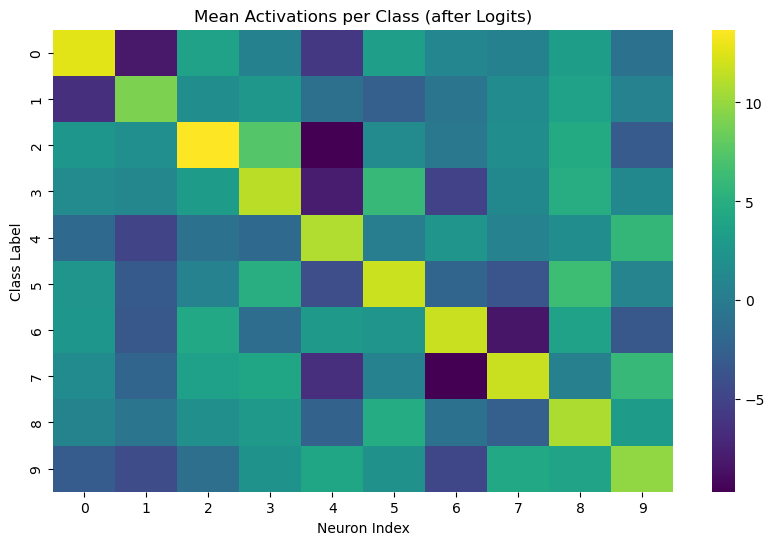

In [1641]:
act_mean_np = mean_activations.numpy()

heatmap(act_mean_np, 'Logits')

### 7.2. Investigating internal activations (ReLU layers)
Next we have a slightly more interesting visual that shows mean activations for the ReLU output of the hidden layers. 

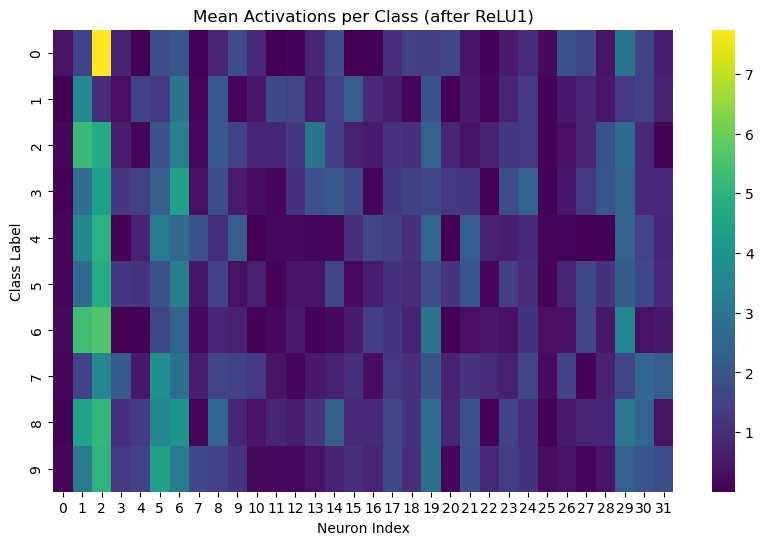

In [1647]:
act_mean_np = mean_activations.numpy()

heatmap(act_mean_np, 'ReLU1')

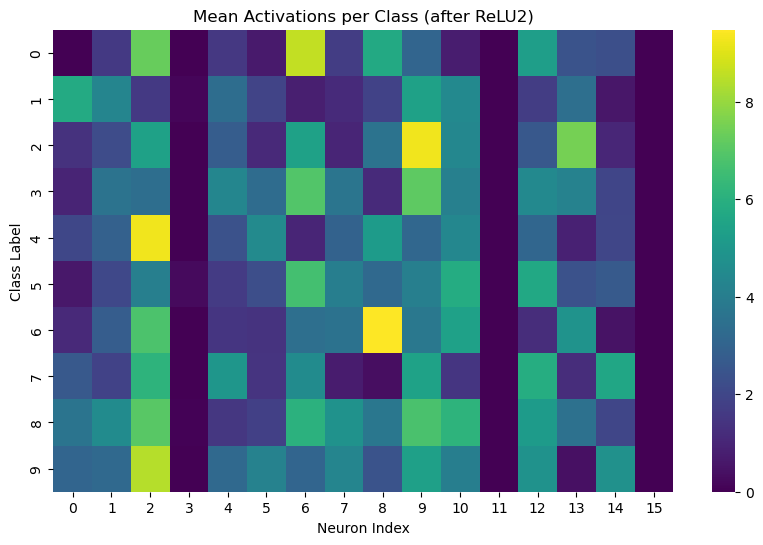

In [1653]:
act_mean_np = mean_activations.numpy()

heatmap(act_mean_np, 'ReLU2')

### 7.2.1. Quick thoughts
In Section 3, we noticed that neuron 2 in the second hidden layer stood out — it had high activations across several classes, suggesting it plays an important role in the network’s predictions about those classes. 

Now, with *activation* heatmaps we see this even more clearly: neuron 2 is consistently active across multiple classes, while many other neurons remain mostly inactive (blue columns). I assumed neuron 2 would not be class-specific, but rather encode a cleanly 'interpretable' feature of multiple digits... we explore this idea a bit more below as we refine our tools.

## 7.3. Exploring some visualizations for neurons in layer 2

### 7.3.1. Gradient based saliency
I did not find this particularly useful- I think in a CNN it would be much nicer (where you see more clear outlines of the digits)- though I did want to try it on some examples. Fun to play with but going to try a 'pixel' activation map next... or, I also found the phrase 'one-hot perturbation' and since I have a paper about 'Adelic perturbations' in number theory I figured I would add that in the next section! :laugh

In [1683]:
candidates = []
for x,y in test_dataset:
    if y in [9]:
        candidates.append((x,y))

i = torch.randint(0, len(candidates), (1,))
print(i.item())

494


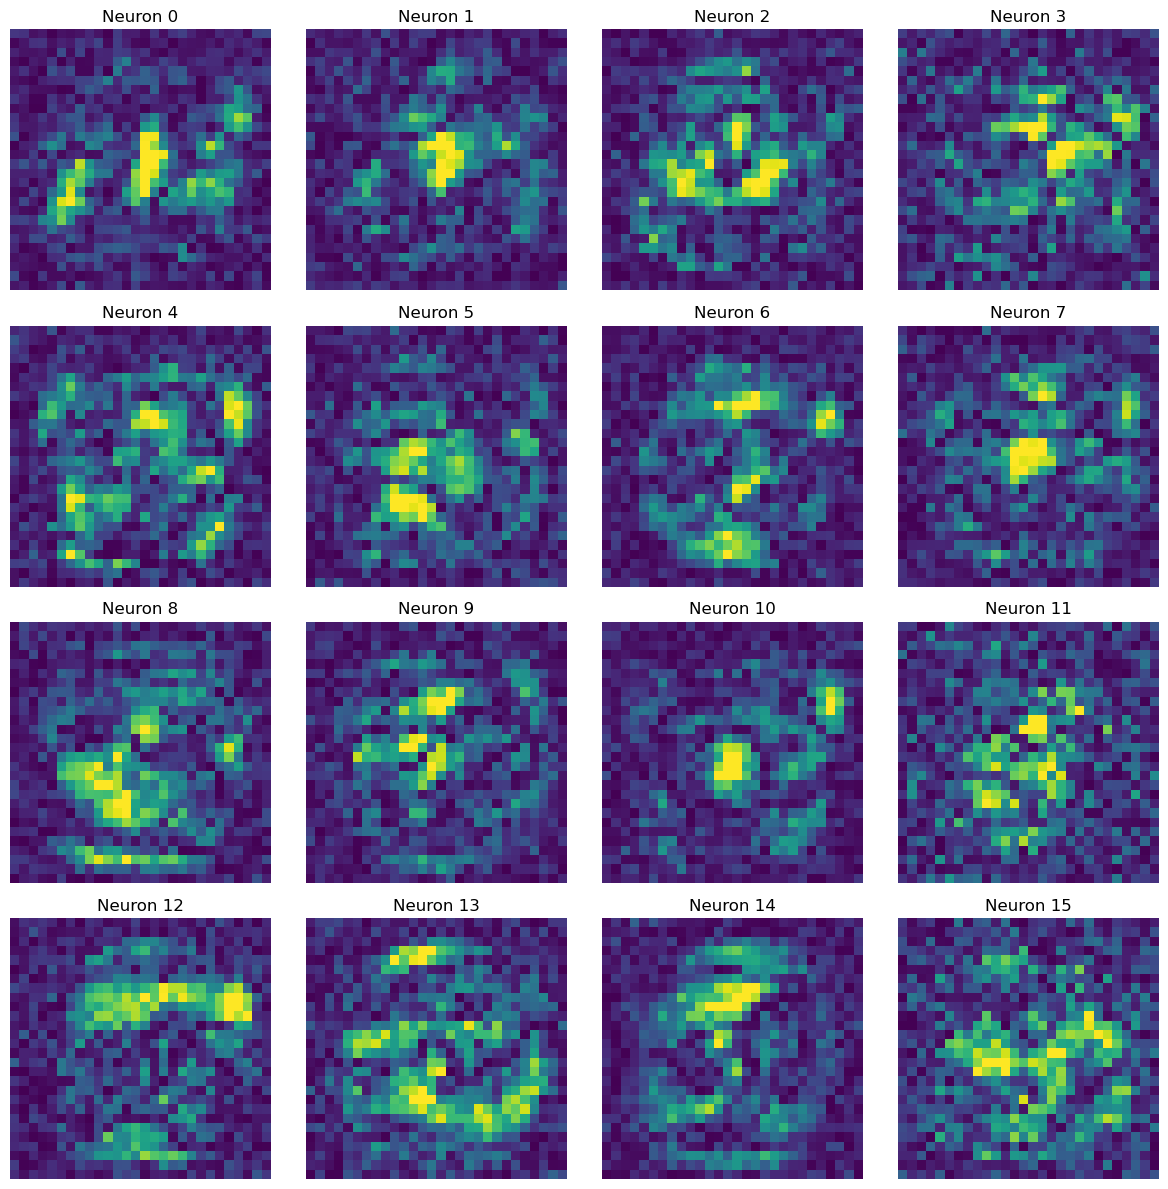

In [1685]:
import numpy as np
from captum.attr import Saliency

# 1) Wrap your model to return the output of linear2 (pre-ReLU layer)
class Linear2Wrapper(torch.nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.m = base_model

    def forward(self, x):
        x = self.m.linear1(x)
        x = self.m.relu1(x)
        x = self.m.linear2(x)  # pre-ReLU output
        return x

# 2) Instantiate the wrapped model
linear2_model = Linear2Wrapper(model).eval()


# 3) Select a test image (already preprocessed into a tensor)
orig_img, _ = candidates[i.item()]
img = orig_img.unsqueeze(0).requires_grad_(True)   # [1, 1, 28, 28]
flat_img = img.view(1, -1)                          # [1, 784] for linear layers

# 4) Prepare Captum’s Saliency object
saliency = Saliency(linear2_model)

# 5) Set up the 4×4 plot
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for idx in range(16):
    ax = axes[idx]

    # 5a) Get gradient wrt input (shape: [1, 784])
    grads = saliency.attribute(flat_img, target=idx)

    # 5b) Reshape and compute gradient × input
    grad = grads.view(28, 28).detach().cpu().numpy()
    inp = img.detach()[0, 0].cpu().numpy()  # [28, 28]
    gxinp = np.abs(grad) # * inp)

    # 5c) Normalize and clip for visual stability
    vmin, vmax = np.percentile(gxinp, [1, 99])
    if vmax - vmin < 1e-5:
        gxinp_norm = np.zeros_like(gxinp)
    else:
        gxinp_norm = np.clip((gxinp - vmin) / (vmax - vmin), 0, 1)

    # 5d) Display
    ax.imshow(gxinp_norm, cmap="viridis")
    ax.set_title(f"Neuron {idx}")
    ax.axis("off")

plt.tight_layout()
plt.show()


### 7.3.2. One-hot perturbations

As discussed above we wish to see what individual pixels the neurons care most about. My hope was that we would be able to see features that the neurons are detecting more clearly wish this visualization. 

In [1670]:
model.eval 

heatmaps = {i: torch.zeros(28, 28) for i in range(16)}

for ind in range(16):
    neuron_index = ind
    heatmap = torch.zeros(28,28)
    
    for i in range(28):
        for j in range(28):
            x = torch.zeros(28, 28)
            x[i,j] = 1.0
    
            with torch.no_grad():
                x1 = model.linear1(x.view(-1, 28*28))
                x2 = model.relu1(x1)
                x3 = model.linear2(x2)
                x4 = model.relu2(x3)
                activation = x4[0][neuron_index]
    
            heatmap[i,j] = activation.item()

    heatmaps[ind] = heatmap

#### The eye of Sauron

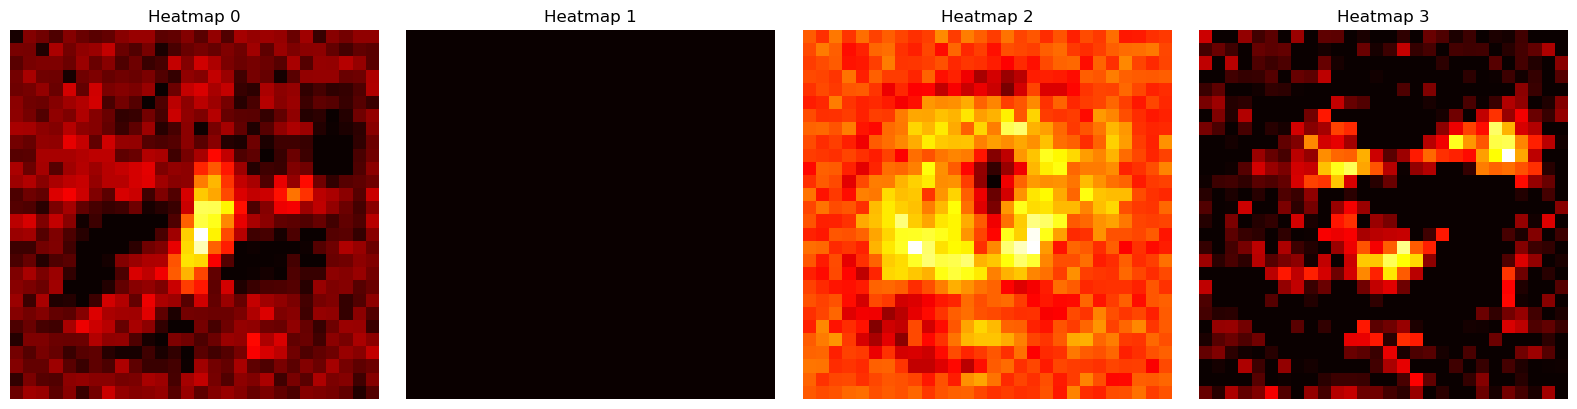

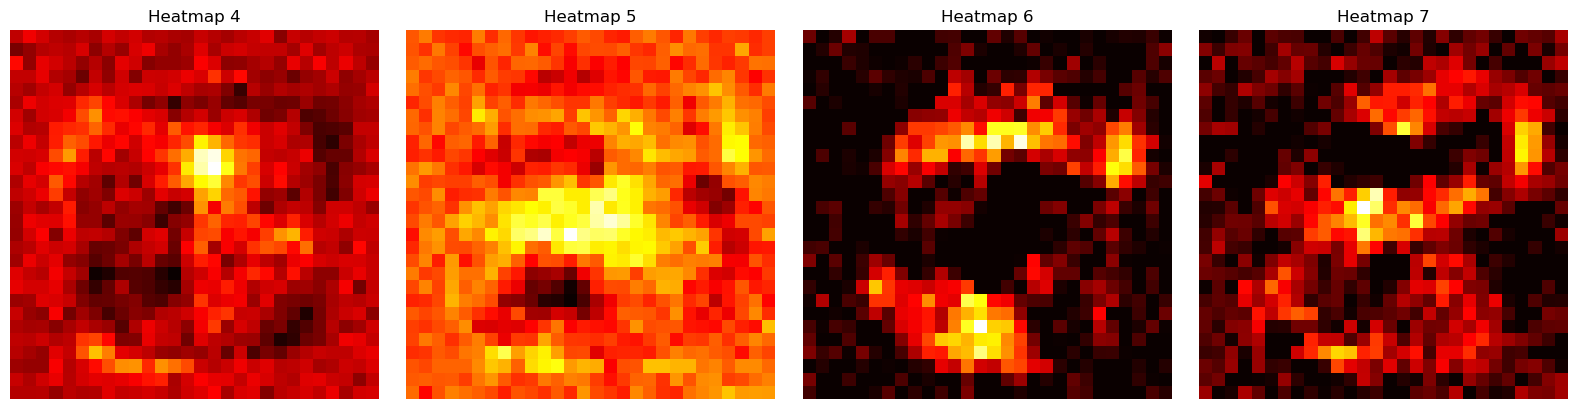

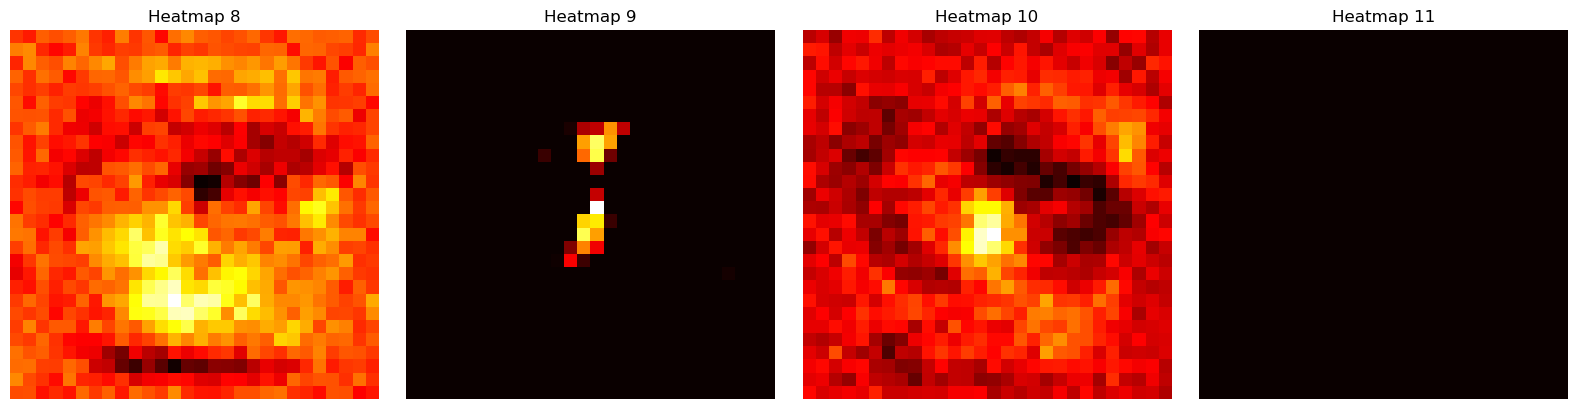

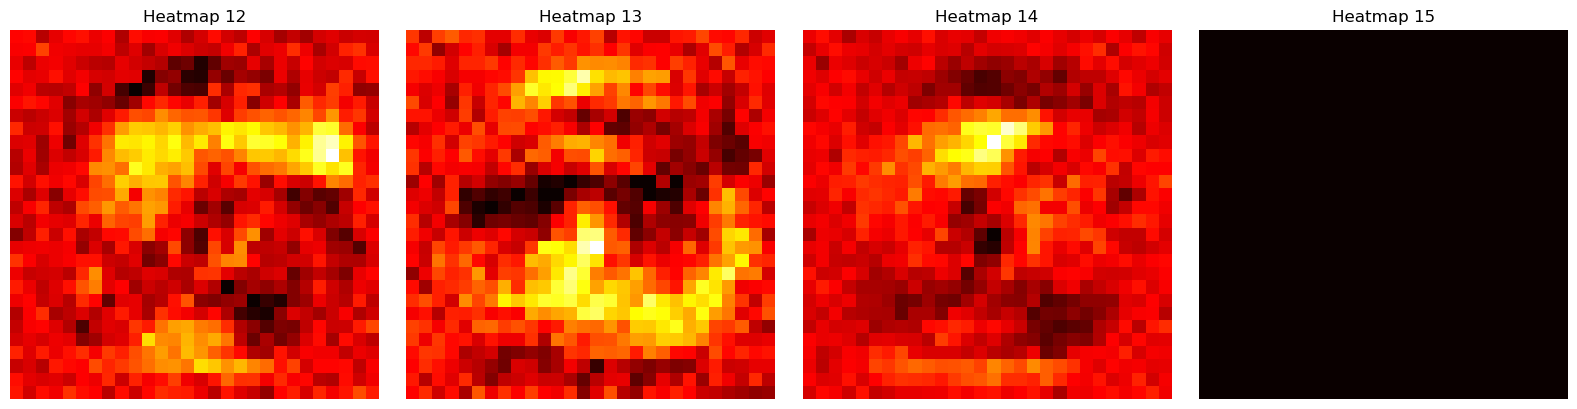

In [1672]:
count = 0
for i in range(4):
    fig, axes = plt.subplots(1, int(len(heatmaps)/4), figsize=(16,4))
    
    for j in range(4):
        axes[j].imshow(heatmaps[count].numpy(), cmap='hot')  # or just `heatmap` if already NumPy
        axes[j].set_title(f'Heatmap {count}')
        axes[j].axis('off')
        count += 1

    plt.tight_layout()
    plt.show()

## 7.4. Some quick observations
In the previous sections we saw hints at seemingly 'important' neurons across the hidden layers and we could start to infer behavior of our network using various visualizations. While these plots are not entirely helpful we do see certain parts of the input that the neurons are focusing on. For example, the 'eye of Sauron' plot shows that neuron 0 activates primarily for input near the center of the image. Neuron 14 activates more for images that have a horizontal feature: this neuron was highly selective for 7 and 9 for example. Neuron 6 was highly selective for class 0, and we can roughly see the features of '0' traced out in the pixel activation plot. Neuron 2 had the highest mean activation across training and test data 

# Section 8: Summary/TODO

In this notebook, we analyzed various aspects of a multi-layer perceptron trained on MNIST (without normalization), with the goal of developing intuition for how internal representations evolve — and how we might understand them.

We explored:

- Activation and gradient statistics, class-wise and neuron-wise
- Neuron specialization, using class selectivity scores and gradient-activation alignment
- Neuron probing experiments, such as ablation and activation scaling, to measure causal influence on logits and class accuracy
- Activation geometry, using PCA, UMAP, and silhouette scores to assess the structure of the hidden layer and its subspaces
- Sparsity experiments, testing how well class separation can be preserved with small, interpretable subsets of neurons

This was a hands-on attempt to build a personal interpretability toolbox, test the limits of simple methods, and lay the groundwork for deeper studies. It included plenty of rabbit holes, visualization experiments, and dead ends — but also some insight into how small networks encode information in complex, class-dependent ways.

### NExt Steps:

In upcoming notebooks, we plan to:
- Repeat these experiments on a normalized MLP, to study how internal geometry and neuron specialization change.
- Animate PCA/UMAP trajectories over training epochs to visualize how class separation emerges.
- Animate UMAP plots over neuron pruning experiments to mirror our silhouette-score graph above
- Explore pruning via class-selective neurons:
    - For example, zeroing out weights unrelated to the top-$k$ neurons of each class: maybe to force specialization.
    - Retraining the model and observing changes in accuracy and interpretability.
    - This is speculative, but it could possibly encourage more disentanglment/clearer features.